In [1]:
from tensorflow.keras import models, layers, optimizers, callbacks, backend
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys
from memory_profiler import profile
import silence_tensorflow.auto

In [2]:
#x_train = np.loadtxt("c_train.txt")  
#y_train = np.loadtxt("s_train.txt")  
#x_test = np.loadtxt("c_test.txt")  
#y_test = np.loadtxt("s_test.txt")  
w0 = np.loadtxt( "frequencies.txt" )

x_train = np.loadtxt("c_train_1_over_f_3.txt")  
y_train = np.loadtxt("s_train_1_over_f_3.txt")  
x_test = np.loadtxt("c_test_1_over_f_3.txt")  
y_test = np.loadtxt("s_test_1_over_f_3.txt") 

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))

x_train =  (29090, 147)
y_train =  (29090, 501)
x_test =  (5818, 147)
y_test =  (5818, 501)
w0 =  (501,)


In [3]:
def get_model( filter_nb, kernel_size, pool_size, learning_rate, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D(filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(1,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )
    
    opt = optimizers.Adam(learning_rate=learning_rate)
    #model.compile(loss='mean_squared_error', optimizer=opt)
    model.compile(loss='MAPE', optimizer=opt)
    
    return model 

In [12]:
model = get_model( filter_nb=80, kernel_size=48, pool_size=2,\
                          learning_rate=0.001, dropout_rate=0.05 )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 147, 80)           3920      
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 80)           307280    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 80)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 74, 40)            153640    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 37, 20)            3

In [4]:
t1 = time.time()
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.25,patience=5,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-6)

model = get_model( filter_nb=40, kernel_size=44, pool_size=2,\
                      learning_rate=0.001, dropout_rate=0.05 )
history_ = model.fit( x_train, y_train, 64, epochs=80,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

print(time.time()-t1)

Epoch 1/80
455/455 [==============================] - 19s 39ms/step - loss: 63.1866 - val_loss: 42.4799 - lr: 0.0010
Epoch 2/80
455/455 [==============================] - 17s 38ms/step - loss: 35.9396 - val_loss: 30.2235 - lr: 0.0010
Epoch 3/80
455/455 [==============================] - 17s 38ms/step - loss: 24.2902 - val_loss: 23.0193 - lr: 0.0010
Epoch 4/80
455/455 [==============================] - 17s 38ms/step - loss: 21.3766 - val_loss: 20.4080 - lr: 0.0010
Epoch 5/80
455/455 [==============================] - 17s 38ms/step - loss: 18.9727 - val_loss: 21.1911 - lr: 0.0010
Epoch 6/80
455/455 [==============================] - 17s 38ms/step - loss: 17.2401 - val_loss: 15.7605 - lr: 0.0010
Epoch 7/80
455/455 [==============================] - 17s 38ms/step - loss: 16.4156 - val_loss: 14.7479 - lr: 0.0010
Epoch 8/80
455/455 [==============================] - 17s 38ms/step - loss: 15.4340 - val_loss: 18.8595 - lr: 0.0010
Epoch 9/80
455/455 [==============================] - 17s 38ms/s

455/455 [==============================] - 17s 38ms/step - loss: 6.5673 - val_loss: 6.4516 - lr: 1.5625e-05
Epoch 67/80
455/455 [==============================] - 17s 38ms/step - loss: 6.5535 - val_loss: 6.3645 - lr: 1.5625e-05
Epoch 68/80
455/455 [==============================] - 17s 38ms/step - loss: 6.5454 - val_loss: 6.4661 - lr: 1.5625e-05
Epoch 69/80
455/455 [==============================] - 17s 38ms/step - loss: 6.5539 - val_loss: 6.4631 - lr: 1.5625e-05
Epoch 70/80
455/455 [==============================] - 17s 38ms/step - loss: 6.5365 - val_loss: 6.4407 - lr: 1.5625e-05
Epoch 71/80
455/455 [==============================] - 17s 38ms/step - loss: 6.5588 - val_loss: 6.4527 - lr: 1.5625e-05
Epoch 72/80
455/455 [==============================] - ETA: 0s - loss: 6.5341
Epoch 72: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
455/455 [==============================] - 17s 38ms/step - loss: 6.5341 - val_loss: 6.3980 - lr: 1.5625e-05
Epoch 73/80
455/455 [========

(0.0, 66.02852690219879)

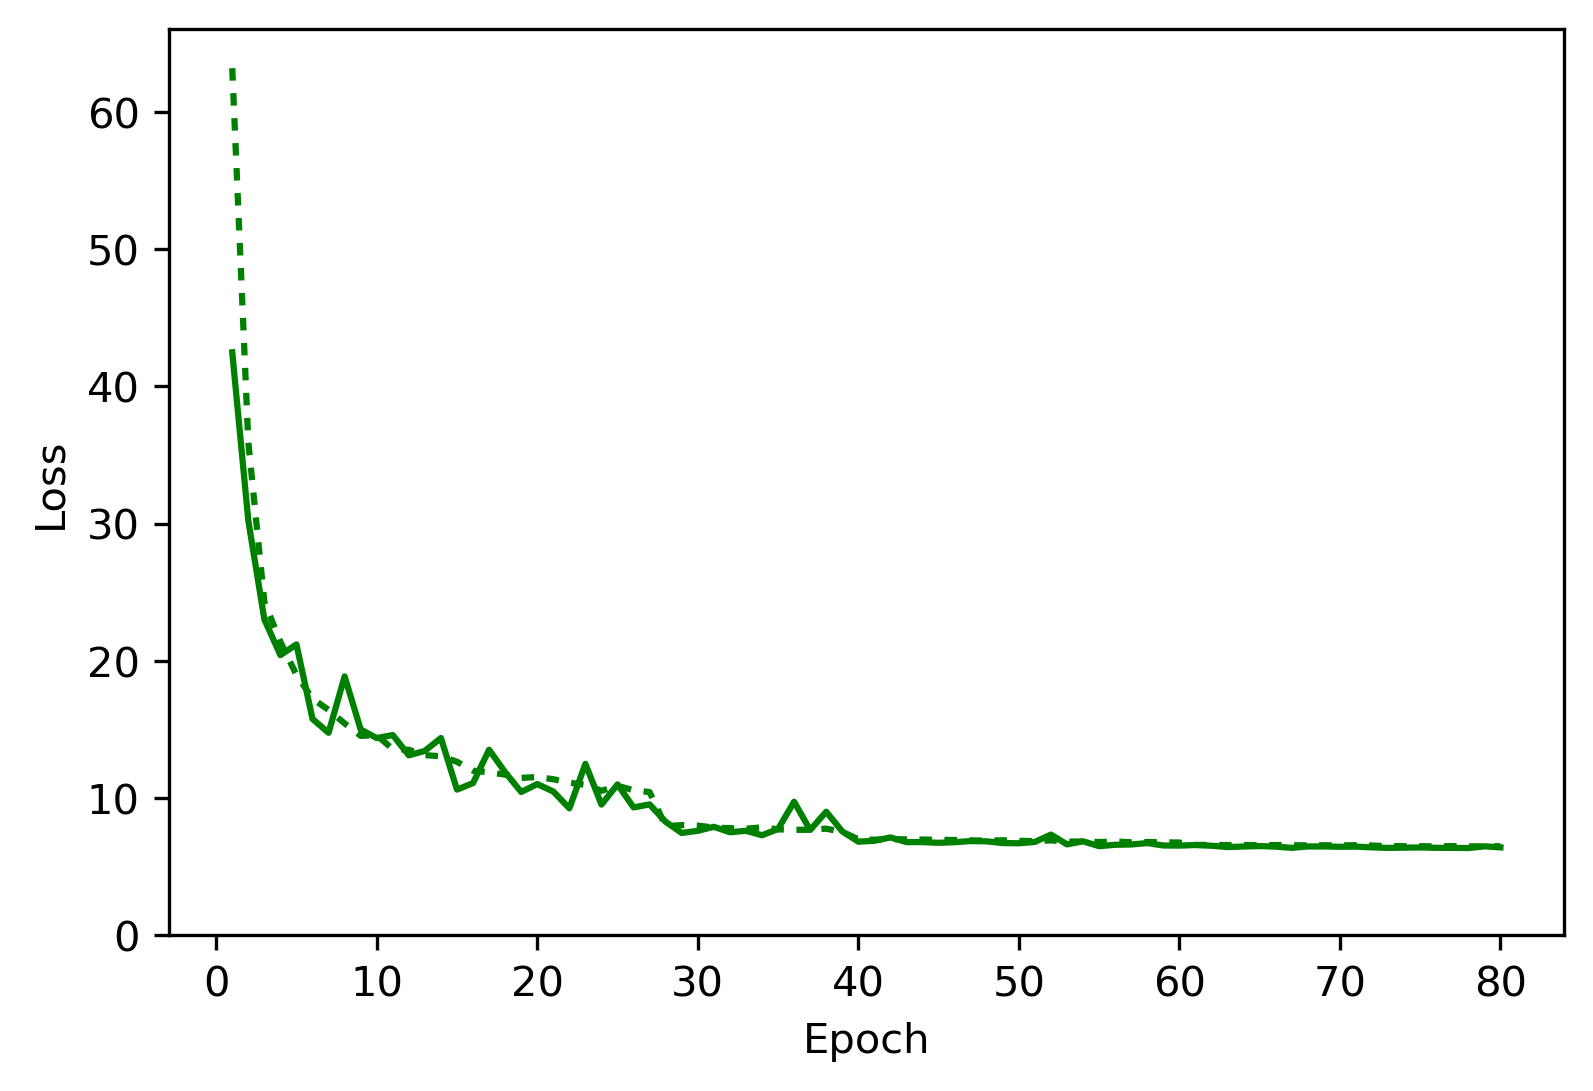

In [16]:
plt.plot( range(1,80+1 ), np.array(history_.history['loss']), dashes=[2,2,2,2],label='loss', c='green')
plt.plot( range(1,80+1 ), np.array(history_.history['val_loss']), label = 'val_loss', c='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0)
#plt.legend(loc='lower right')

In [22]:
label1 = 'number_of_filters'
label2 = 'kernel_size'

parameters1_arr = np.arange( 20,80 )  #-- number of filters
parameters2_arr = np.arange( 12,48 )  #-- kernel size
pairs = []
for p1 in parameters1_arr:
    for p2 in parameters2_arr:
        pairs.append([p1,p2])
        
training_losses = {}
validation_losses = {}

nb_of_points = len(parameters1_arr)*len(parameters2_arr)
print(label1, parameters1_arr)
print(label2, parameters2_arr)
print(len(parameters1_arr),len(parameters2_arr),nb_of_points)

number_of_filters [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79]
kernel_size [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47]
60 36 2160


In [23]:
epochs=20
best_loss = 1000
worst_loss = -1

t1=time.time()
print('-- nb of points =',nb_of_points )

from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d_%m||%Hh%M")

if (nb_of_points != len(pairs)):
    print("-- ABORT: parameter sweep already started.")
    sys.exit()


count=0
while pairs:
    count +=1
    rand_int = np.random.randint(0, len(pairs))
    pair = pairs[rand_int]
    p1 = int( pair[0] )
    p2 = int( pair[1] )
    pairs.remove(pair)

    print('.',end=' ' )
    
    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5,verbose=0,\
        mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-5)
    model = get_model( filter_nb=p1, kernel_size=p2, pool_size=2,\
                      learning_rate=0.001, dropout_rate=0.05 )
    history_ = model.fit( x_train, y_train, 64, epochs=epochs,\
                         validation_data=(x_test, y_test), verbose=0)#, callbacks=[reduce_lr])

    training_losses[ p1 , p2 ] = history_.history['loss'][-1]
    validation_losses[ p1 ,p2 ] = history_.history['val_loss'][-1]
    if count > 20:
        with open('training/training_losses_'+t_string+'.pkl', 'wb') as f1:
            pickle.dump(training_losses, f1)
        with open('training/validation_losses_'+t_string+'.pkl', 'wb') as f2:
            pickle.dump(validation_losses, f2)

    if (validation_losses[ p1 , p2 ] < best_loss):
        if count > 20:
            with open('training/best_history_'+t_string+'.pkl', 'wb') as f3:
                pickle.dump(history_.history, f3)
        best_loss = validation_losses[ p1 , p2 ]
        model.save('training/best_model'+t_string, overwrite=True)
        best_p1=p1
        best_p2=p2


t2=time.time()
print(' ')
print('=== COMPLETE ===')
print("-- total time = ", t2-t1)
print("-- best {}, {} =".format(label1, label2), best_p1, best_p2)
print("-- t_string", t_string)


-- nb of points = 2160
. 

. 

. . . . . . . . . . . . . . 

. . . . . . . 

. 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

. . . . . . . . . . . . . . . . . . . . 

KeyboardInterrupt: 

Best parameters = 40 44 9.446722030639648


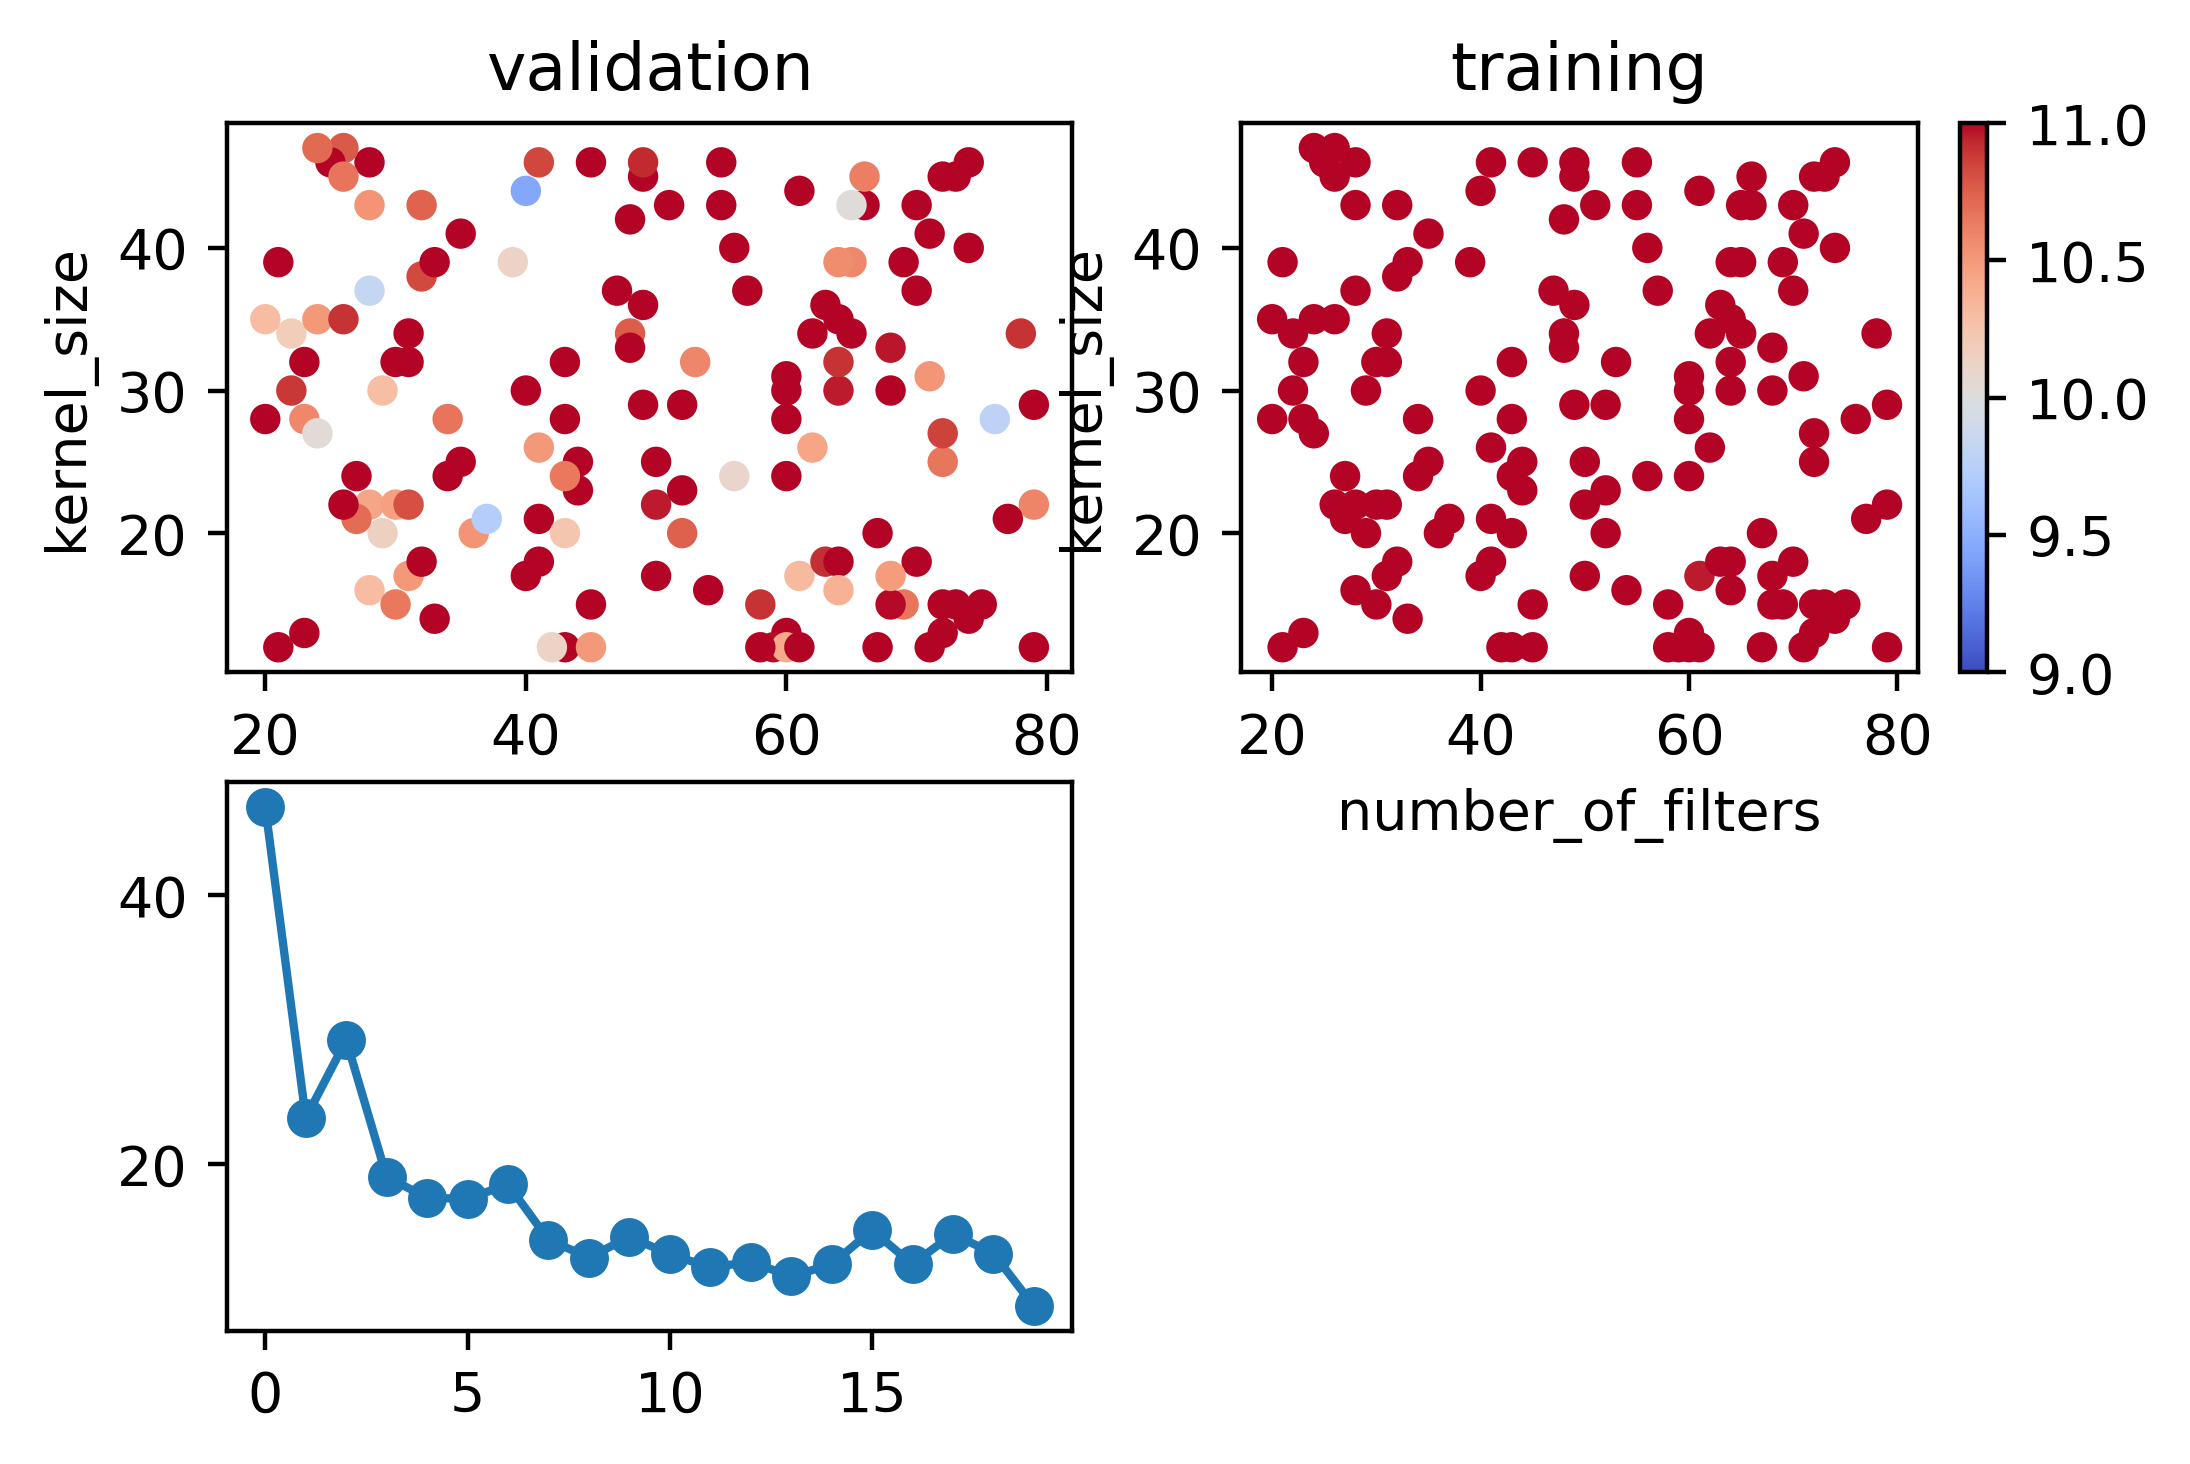

In [46]:
matplotlib.rcParams['figure.dpi']=400
#t_string="24_04||11h20"
with open('training/training_losses_'+t_string+'.pkl', 'rb') as f1:
    training_losses = pickle.load(f1)
with open('training/validation_losses_'+t_string+'.pkl', 'rb') as f2:
    validation_losses = pickle.load(f2)
with open('training/best_history_'+t_string+'.pkl', 'rb') as f3:
    best_history = pickle.load(f3)


min_val = min(validation_losses, key=validation_losses.get)
print( "Best parameters =", min_val[0], min_val[1],validation_losses[min_val] )

x_scatter = [ x[0] for x in training_losses]
y_scatter = [ x[1] for x in training_losses]
training_colors = [training_losses[x] for x in training_losses]
validation_colors = [validation_losses[x] for x in training_losses]


plt.subplot(2,2,1)
mycmap = plt.cm.coolwarm
lognorm=matplotlib.colors.LogNorm()
vals = list(validation_losses.values())
plt.scatter( x_scatter, y_scatter, s=20, c=validation_colors, cmap=mycmap)#,norm=lognorm )
plt.xlabel(label1)
plt.ylabel(label2)
plt.clim(9, 11)
plt.title( 'validation' )


plt.subplot(2,2,2)
vals = list(training_losses.values())
lognorm=matplotlib.colors.LogNorm()
mycmap = plt.cm.coolwarm
plt.scatter( x_scatter, y_scatter, s=20, c=training_colors, cmap=mycmap)#,norm=lognorm )
plt.xlabel(label1)
plt.ylabel(label2)
plt.title( 'training' )
plt.clim(9, 11)
plt.colorbar()

plt.subplot(2,2,3)
plt.scatter( np.arange(len(best_history['val_loss'])), best_history['val_loss'] )
plt.plot( np.arange(len(best_history['val_loss'])), best_history['val_loss'] )
plt.savefig('training/plots/'+t_string+'.pdf',format='pdf')
plt.show()

In [8]:
reconstructed_model = models.load_model('training/best_model'+t_string)

NameError: name 't_string' is not defined

In [9]:
probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

182/182 [==============================] - 1s 7ms/step


(1000.0, 1000000.0)

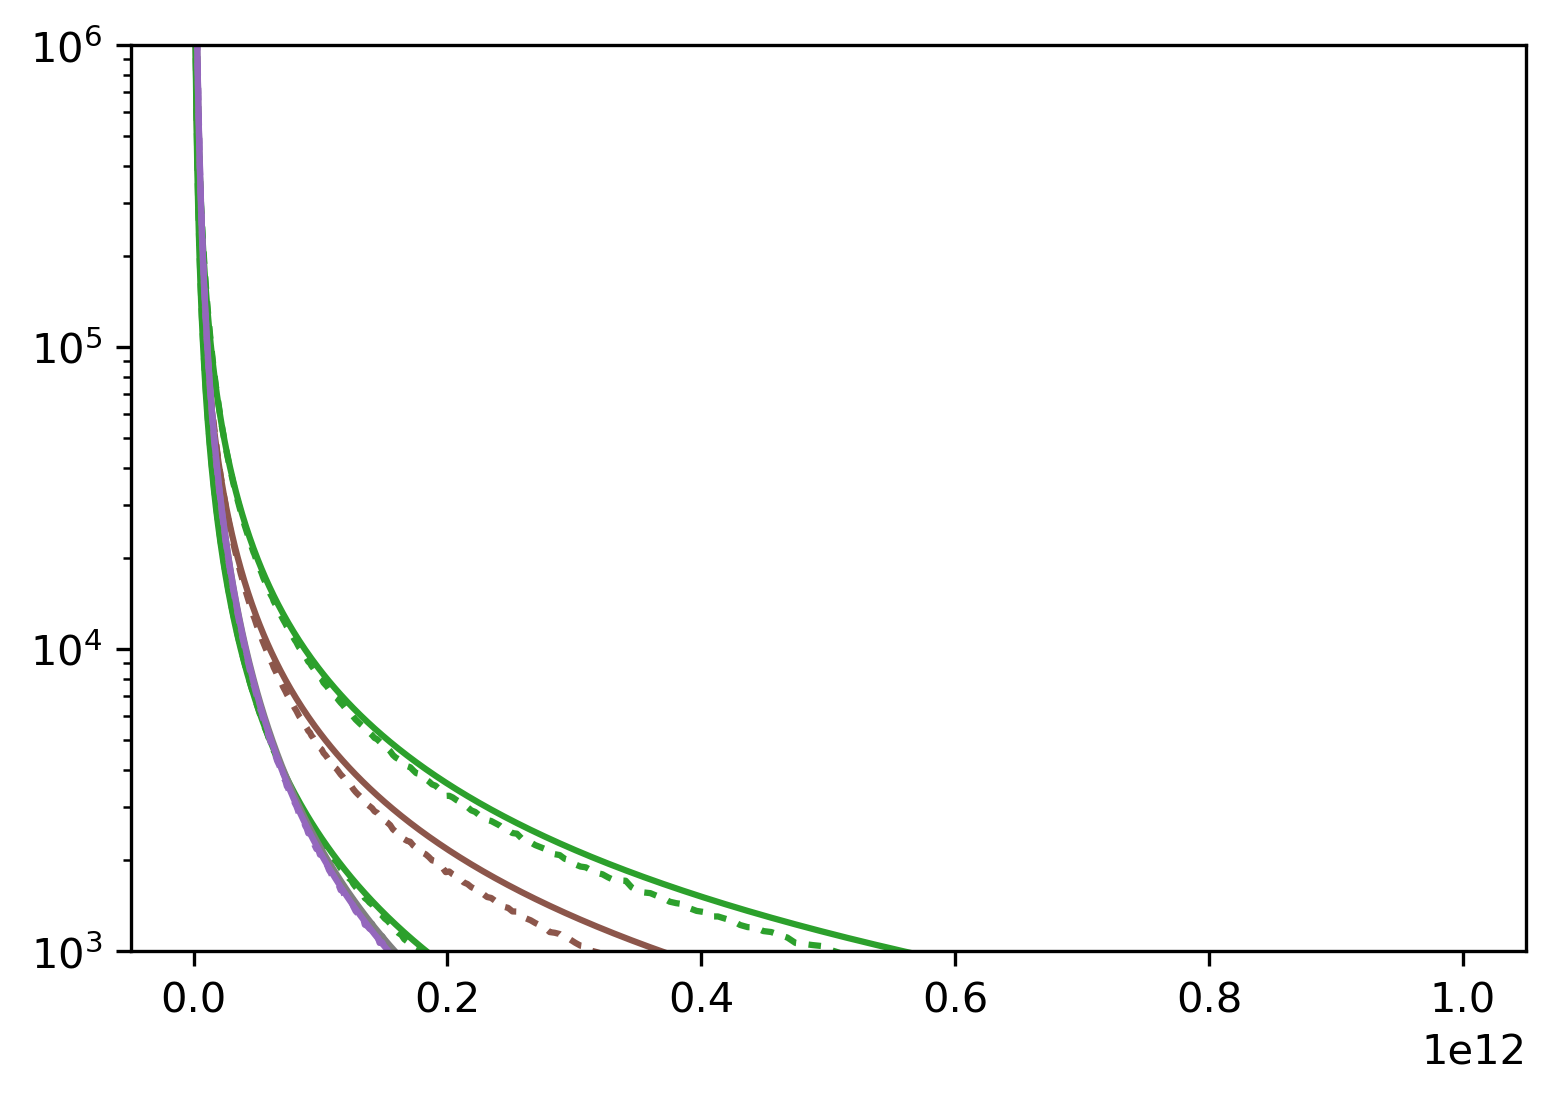

In [15]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e3,1e6)

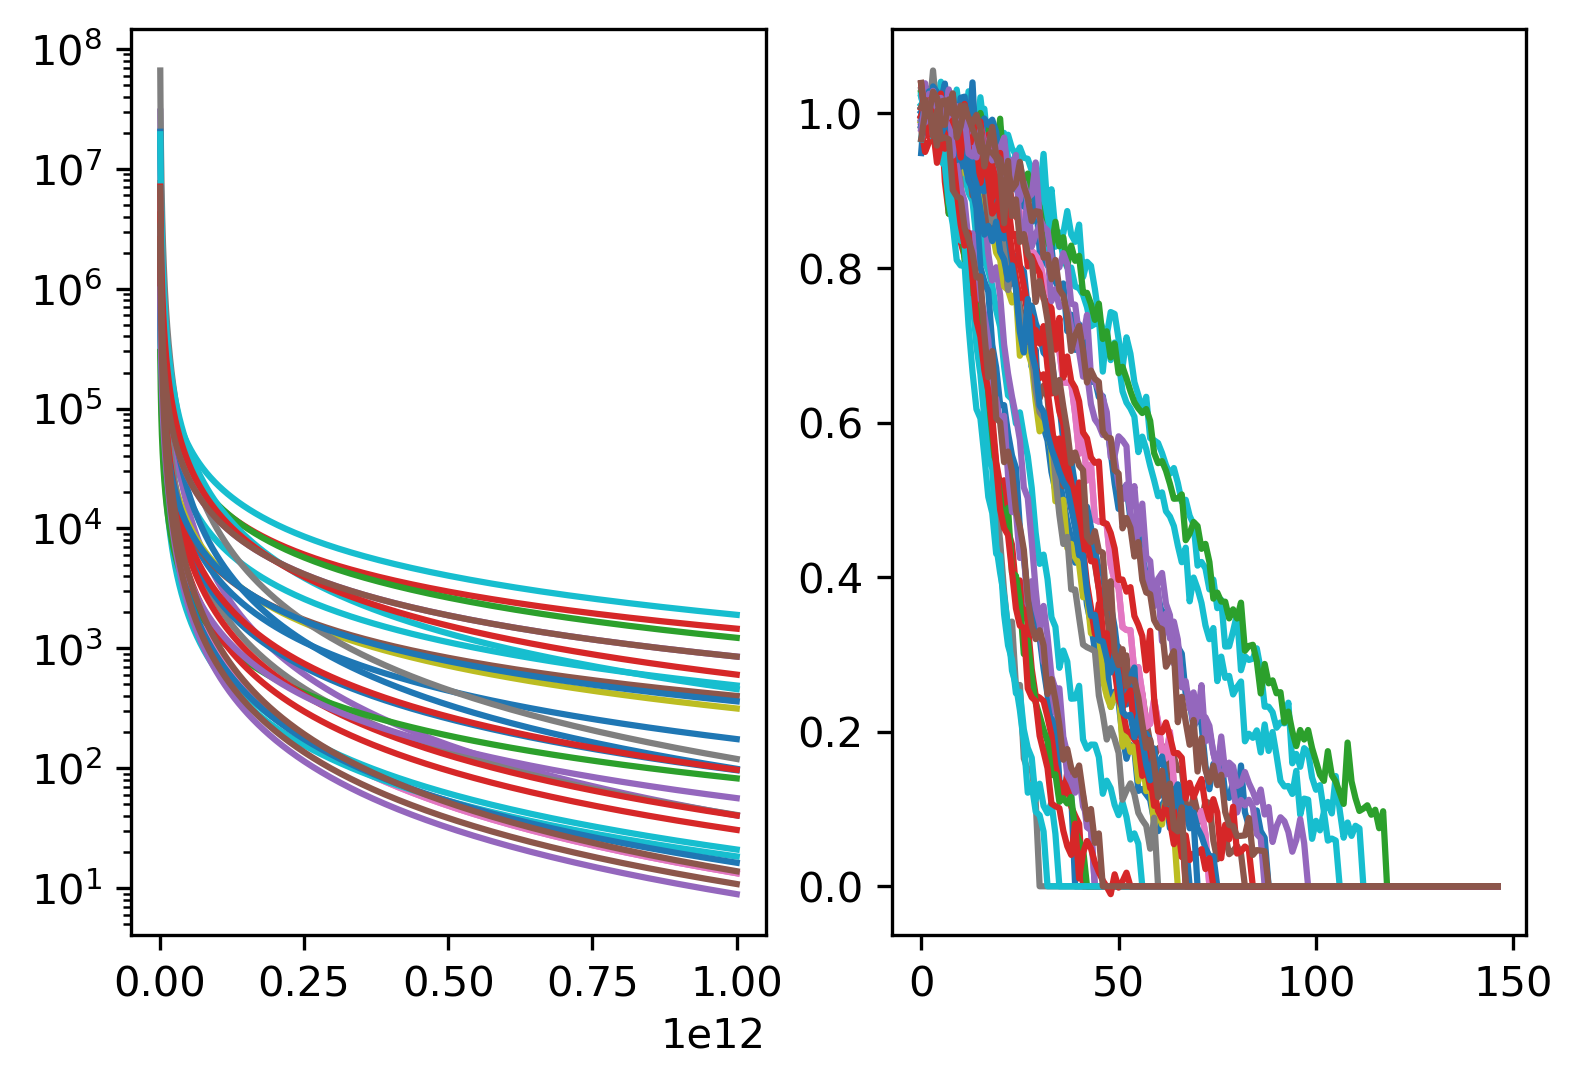

In [14]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))

In [37]:
validation_losses

{(52, 29): 12.280069351196289,
 (28, 22): 10.445279121398926,
 (69, 15): 10.662707328796387,
 (74, 40): 11.924968719482422,
 (79, 12): 11.903802871704102,
 (20, 28): 14.10513687133789,
 (75, 15): 11.984048843383789,
 (49, 45): 98.20396423339844,
 (49, 29): 11.42209243774414,
 (35, 25): 12.064530372619629,
 (66, 43): 12.12700366973877,
 (70, 43): 12.222420692443848,
 (50, 22): 10.957698822021484,
 (71, 31): 10.522311210632324,
 (21, 39): 11.283363342285156,
 (61, 17): 10.31566047668457,
 (67, 12): 11.425739288330078,
 (60, 31): 11.928427696228027,
 (40, 30): 14.074586868286133,
 (74, 46): 11.207980155944824,
 (64, 35): 13.250297546386719,
 (60, 13): 98.2032241821289,
 (29, 30): 10.291311264038086,
 (76, 28): 9.786140441894531,
 (43, 12): 11.449771881103516,
 (31, 32): 11.71078872680664,
 (22, 34): 10.182755470275879,
 (23, 28): 10.582271575927734,
 (59, 12): 10.978233337402344,
 (28, 46): 11.145133018493652,
 (52, 23): 12.15572738647461,
 (63, 18): 10.908235549926758,
 (66, 45): 10.6175

In [39]:
validation_losses[40,44]

9.446722030639648

In [45]:
mmin=min(validation_losses, key=validation_losses.get)

(20, 28)